In [65]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import pandas as pd
import cvxopt
import cvxopt.solvers

In [75]:
data=pd.read_csv('2017EE30149.csv', header=None)
data=np.array(data)
n=3000
m=25
x1=data[0:n,0:25]
t1=data[0:n,25]

In [76]:
class1=5
class2=6
x=np.reshape([],(0,m))
t=[]
for i in range(n):
    if t1[i]==class1:
        x=np.concatenate((x,x1[i:i+1]),axis=0)
        t.append(1)
    if t1[i]==class2:
        x=np.concatenate((x,x1[i:i+1]),axis=0)
        t.append(-1)
        
n=len(t)

In [77]:
def kernelL(x1,x2):
    return np.dot(x1,x2)

In [78]:
def kernelR(x1,x2,gm):
    return np.exp((-linalg.norm(x1-x2)**2)*(gm))

In [71]:
def accuracy(y_pred,t_test):
    a=0
    k=len(t_test)
    for i in range(k):
        if y_pred[i]==t_test[i]:
            a=a+1
    return a/k

In [25]:
def crossScoreR(folds,c,gm):
    b=n//folds
    ac=0
    y=[]
    y1=[]
    f=0
    for i in range(folds):
        temp=np.array(x[f:f+b,0:m])
        temp1=np.array(t[f:f+b])
        f=f+b
        y.append(temp)
        y1.append(temp1)
    
    for i in range(folds):
        x_test=y[i]
        t_test=y1[i]
        x_train=np.reshape([],(0,m))
        t_train=[]
        
        for j in range(folds):
            if i!=j:
                x_train=np.concatenate((x_train,y[j]),axis=0)
                t_train=np.concatenate((t_train,y1[j]),axis=0)
             

        ac+=cvxR(x_train,t_train,c,gm)
    
    return ac/folds

In [30]:
def crossScoreL(folds,c):
    b=n//folds
    ac=0
    y=[]
    y1=[]
    f=0
    for i in range(folds):
        temp=np.array(x[f:f+b,0:m])
        temp1=np.array(t[f:f+b])
        f=f+b
        y.append(temp)
        y1.append(temp1)
    
    for i in range(folds):
        x_test=y[i]
        t_test=y1[i]
        x_train=np.reshape([],(0,m))
        t_train=[]
        
        for j in range(folds):
            if i!=j:
                x_train=np.concatenate((x_train,y[j]),axis=0)
                t_train=np.concatenate((t_train,y1[j]),axis=0)
             

        ac+=cvxL(x_train,t_train,c)
    
    return ac/folds

In [31]:
crossScoreL(4,0.1)

     pcost       dcost       gap    pres   dres
 0: -1.3228e+01 -7.1276e+01  2e+03  2e+01  2e-14
 1: -2.3684e+00 -6.3634e+01  1e+02  8e-01  2e-14
 2: -1.0472e+00 -2.0813e+01  3e+01  1e-01  5e-15
 3: -3.6132e-01 -7.1850e+00  1e+01  4e-02  2e-15
 4: -1.5274e-01 -1.2527e+00  1e+00  5e-03  1e-15
 5: -1.8341e-01 -5.9739e-01  5e-01  1e-03  8e-16
 6: -2.3376e-01 -3.8048e-01  2e-01  2e-04  8e-16
 7: -2.6065e-01 -3.1146e-01  5e-02  4e-05  8e-16
 8: -2.6712e-01 -2.9857e-01  3e-02  8e-06  8e-16
 9: -2.7909e-01 -2.8184e-01  3e-03  6e-07  9e-16
10: -2.8024e-01 -2.8029e-01  5e-05  1e-08  1e-15
11: -2.8026e-01 -2.8026e-01  7e-07  1e-10  9e-16
12: -2.8026e-01 -2.8026e-01  7e-09  1e-12  9e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.3054e+01 -7.1261e+01  2e+03  2e+01  3e-14
 1: -2.3526e+00 -6.3629e+01  1e+02  9e-01  2e-14
 2: -1.0333e+00 -2.0871e+01  3e+01  1e-01  5e-15
 3: -3.6910e-01 -5.8942e+00  8e+00  3e-02  2e-15
 4: -1.9388e-01 -1.0835e+00  1e+00  4e-03  1e-1

1.0

In [73]:
def cvxR(xTrain,tTrain,C,gm):
    n=len(xTrain)
    K=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
    #         K[i,j]=kernelL(x[i],x[j])
            K[i,j]=kernelR(xTrain[i],xTrain[j],gm)
        
    P=cvxopt.matrix(np.outer(tTrain,tTrain)*K) #K is kernel matrix
    q=cvxopt.matrix(np.ones(n)*(-1))
    A=cvxopt.matrix(tTrain,(1,n),tc='d')
    b=cvxopt.matrix(0, tc='d')
    G=cvxopt.matrix(np.vstack((np.diag(np.ones(n)*(-1)),np.identity(n))))
    h=cvxopt.matrix(np.hstack((np.zeros(n),np.ones(n)*C)))   
    solution=cvxopt.solvers.qp(P,q,G,h,A,b)
    a=np.ravel(solution['x']) #Lagrange Multipliers
    sv=a > 1e-5 #Support Vectors
    sv_a=a[sv]
    sv_x=xTrain[sv]
    tTrain=np.array(tTrain,dtype=int)
    sv_t=tTrain[sv]
    sv_index=np.arange(len(a))[sv]
    print(len(sv_index))
    print(sv_index)
    plt.scatter(range(len(sv_index)),sv_index)
    intercept=0
    for i in range(len(sv_a)):
        intercept+=sv_t[i]
        temp=0
        for j in range(len(sv_a)):
            temp+=sv_t[j]*sv_a[j]*K[sv_index[i],sv_index[j]]
        intercept-=temp 
    intercept/=len(sv_a)
    print(intercept)
    y_pred=np.zeros(len(xTrain))
    for i in range(len(xTrain)):
        s=0
        for j in range(len(sv_a)):
            s+=sv_a[j]*sv_t[j]*K[i,sv_index[j]]
        y_pred[i]=s
    y_pred+=intercept
    y_pred=np.sign(y_pred) #Prediction on given data set
    return accuracy(y_pred,tTrain)

     pcost       dcost       gap    pres   dres
 0: -5.8895e+01 -9.3274e+02  3e+03  2e+00  6e-16
 1: -4.4457e+01 -4.7761e+02  5e+02  5e-02  7e-16
 2: -6.1507e+01 -1.2394e+02  6e+01  6e-03  6e-16
 3: -6.8212e+01 -7.9934e+01  1e+01  9e-04  5e-16
 4: -7.0124e+01 -7.2040e+01  2e+00  6e-05  5e-16
 5: -7.0529e+01 -7.0836e+01  3e-01  8e-06  5e-16
 6: -7.0613e+01 -7.0638e+01  3e-02  5e-07  5e-16
 7: -7.0621e+01 -7.0622e+01  1e-03  2e-08  5e-16
 8: -7.0622e+01 -7.0622e+01  5e-05  4e-10  5e-16
Optimal solution found.
373
[  2   3   8   9  10  12  13  15  16  17  18  19  21  22  23  25  26  27
  28  31  33  34  35  37  38  42  46  47  48  50  52  53  57  58  59  61
  64  65  66  68  69  70  71  72  73  74  77  78  79  80  81  82  84  85
  86  88  89  92  93  94  95  96  97  98 100 102 103 104 106 108 109 110
 113 114 118 119 122 123 125 126 127 133 134 136 137 139 140 142 143 145
 147 151 157 158 159 161 162 163 164 165 166 167 168 170 171 172 173 174
 175 176 177 178 181 182 185 187 188 189 193 

1.0

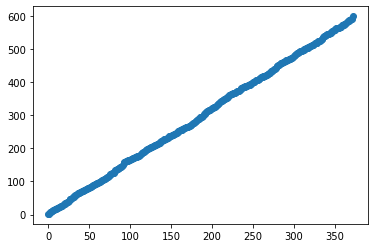

In [74]:
cvxR(x,t,0.99,0.09)

In [80]:
def cvxL(xTrain,tTrain,C):
    n=len(xTrain)
    K=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            K[i,j]=kernelL(xTrain[i],xTrain[j])
#             K[i,j]=kernelR(xTrain[i],xTrain[j],gm)
        
    P=cvxopt.matrix(np.outer(tTrain,tTrain)*K) #K is kernel matrix
    q=cvxopt.matrix(np.ones(n)*(-1))
    A=cvxopt.matrix(tTrain,(1,n),tc='d')
    b=cvxopt.matrix(0, tc='d')
    G=cvxopt.matrix(np.vstack((np.diag(np.ones(n)*(-1)),np.identity(n))))
    h=cvxopt.matrix(np.hstack((np.zeros(n),np.ones(n)*C)))   
    solution=cvxopt.solvers.qp(P,q,G,h,A,b)
    a=np.ravel(solution['x']) #Lagrange Multipliers
    sv=a > 1e-5 #Support Vectors
    sv_a=a[sv]
    sv_x=xTrain[sv]
    tTrain=np.array(tTrain,dtype=int)
    sv_t=tTrain[sv]
    sv_index=np.arange(len(a))[sv]
    print(len(sv_index))
    print(sv_index)
    intercept=0
    for i in range(len(sv_a)):
        intercept+=sv_t[i]
        temp=0
        for j in range(len(sv_a)):
            temp+=sv_t[j]*sv_a[j]*K[sv_index[i],sv_index[j]]
        intercept-=temp 
    intercept/=len(sv_a)
    print(intercept)
    y_pred=np.zeros(len(xTrain))
    for i in range(len(xTrain)):
        s=0
        for j in range(len(sv_a)):
            s+=sv_a[j]*sv_t[j]*K[i,sv_index[j]]
        y_pred[i]=s
    y_pred+=intercept
    y_pred=np.sign(y_pred) #Prediction on given data set
    return accuracy(y_pred,tTrain)

In [81]:
cvxL(x,t,0.1)

     pcost       dcost       gap    pres   dres
 0: -7.0936e+01 -1.1656e+02  4e+03  3e+01  4e-14
 1: -1.2367e+01 -1.0717e+02  3e+02  1e+00  4e-14
 2: -7.8079e+00 -4.7819e+01  6e+01  2e-01  8e-15
 3: -5.6460e+00 -1.8158e+01  2e+01  5e-02  4e-15
 4: -5.2934e+00 -8.4791e+00  4e+00  1e-02  3e-15
 5: -5.4980e+00 -6.7262e+00  1e+00  3e-03  3e-15
 6: -5.6232e+00 -6.1808e+00  6e-01  1e-03  3e-15
 7: -5.7328e+00 -5.8700e+00  2e-01  2e-04  4e-15
 8: -5.7725e+00 -5.7817e+00  1e-02  9e-06  4e-15
 9: -5.7760e+00 -5.7763e+00  3e-04  3e-07  4e-15
10: -5.7761e+00 -5.7761e+00  3e-06  3e-09  4e-15
Optimal solution found.
79
[ 17  23  27  33  47  58  66  71  79  85  86  88  92  97 102 118 123 126
 127 158 162 166 174 182 195 203 209 217 227 229 241 243 251 252 263 266
 271 279 283 290 303 309 324 342 344 351 353 355 372 379 383 385 388 390
 393 406 413 416 428 435 438 439 453 460 495 498 504 510 543 564 565 567
 568 576 577 582 591 592 599]
1.710445096164121


0.97

In [6]:
C=0.944
gm=0.09
K=np.zeros((n,n))
for i in range(n):
    for j in range(n):
#         K[i,j]=kernelL(x[i],x[j])
        K[i,j]=kernelR(x[i],x[j],gm)
        
P=cvxopt.matrix(np.outer(t,t)*K) #K is kernel matrix
q=cvxopt.matrix(np.ones(n)*(-1))
A=cvxopt.matrix(t,(1,n),tc='d')
b=cvxopt.matrix(0, tc='d')
G=cvxopt.matrix(np.vstack((np.diag(np.ones(n)*(-1)),np.identity(n))))
h=cvxopt.matrix(np.hstack((np.zeros(n),np.ones(n)*C)))

In [7]:
solution=cvxopt.solvers.qp(P,q,G,h,A,b)
a=np.ravel(solution['x']) #Lagrange Multipliers
print(a)

     pcost       dcost       gap    pres   dres
 0: -1.8416e+01 -7.2164e+02  3e+03  2e+00  7e-16
 1: -8.2200e+00 -3.0789e+02  3e+02  5e-02  8e-16
 2: -1.9609e+01 -5.4886e+01  4e+01  4e-03  8e-16
 3: -2.2767e+01 -3.1361e+01  9e+00  8e-04  5e-16
 4: -2.3705e+01 -2.6312e+01  3e+00  2e-04  4e-16
 5: -2.4025e+01 -2.5130e+01  1e+00  5e-05  4e-16
 6: -2.4209e+01 -2.4467e+01  3e-01  4e-15  4e-16
 7: -2.4260e+01 -2.4298e+01  4e-02  4e-15  4e-16
 8: -2.4270e+01 -2.4272e+01  2e-03  5e-15  4e-16
 9: -2.4271e+01 -2.4271e+01  7e-05  2e-15  4e-16
10: -2.4271e+01 -2.4271e+01  2e-06  3e-15  4e-16
Optimal solution found.
[4.04680070e-08 8.34591914e-03 3.54801644e-09 6.24196862e-09
 1.06991316e-01 7.17442149e-09 7.70052795e-09 1.29860568e-07
 2.83702902e-09 3.02879754e-02 7.25701007e-02 1.29260513e-07
 1.76957142e-01 4.07725204e-09 1.49252278e-04 4.04861279e-09
 3.93206394e-09 2.93609295e-01 1.15343750e-01 3.47546792e-09
 5.47376105e-09 7.50651888e-02 3.48244915e-09 1.20478376e-07
 3.54056134e-01 2.41356

In [8]:
sv=a > 1e-5 #Support Vectors
sv_a=a[sv]
sv_x=x[sv]
t=np.array(t,dtype=int)
sv_t=t[sv]
sv_index=np.arange(len(a))[sv]

In [9]:
intercept=0
for i in range(len(sv_a)):
    intercept+=sv_t[i]
    temp=0
    for j in range(len(sv_a)):
        temp+=sv_t[j]*sv_a[j]*K[sv_index[i],sv_index[j]]
    intercept-=temp 
intercept/=len(sv_a)
print(intercept)

0.6329107924674614


In [11]:
sv_index.shape

(270,)

In [12]:
y_pred=np.zeros(len(x))
for i in range(len(x)):
    s=0
    for j in range(len(sv_a)):
        s+=sv_a[j]*sv_t[j]*K[i,sv_index[j]]
    y_pred[i]=s
y_pred+=intercept
y_pred=np.sign(y_pred) #Prediction on given data set

In [14]:
accuracy(y_pred,t)

1.0